In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [2]:
# dataset name
csv_file = "realData.csv"
# make dataframe of data
df = pd.read_csv(csv_file)

# remove outliers (words longer than 10 characters)
df_filtered = df[df["length"] <= 10].copy()

print(df_filtered.head())

  word_JAP          word_US word_POS phrase_JAP             img_title  \
0       新装  Newly available     noun        新装板  DL-Raw.Net_1 (2).jpg   
1        板            Board  unknown        新装板  DL-Raw.Net_1 (2).jpg   
2       板垣          Itagaki     noun       板垣恵介  DL-Raw.Net_1 (2).jpg   
3       恵介          Keisuke     noun       板垣恵介  DL-Raw.Net_1 (2).jpg   
4       新装  Newly available     noun        新装板      DL-Raw.Net_1.jpg   

   img_series  length  confidence  word_freq  hiragana_ratio  katakana_ratio  \
0  Hanma_Baki       2        0.65     0.0006             0.0             0.0   
1  Hanma_Baki       1        0.65     0.0014             0.0             0.0   
2  Hanma_Baki       2        0.96     0.0043             0.0             0.0   
3  Hanma_Baki       2        0.96     0.0045             0.0             0.0   
4  Hanma_Baki       2        0.88     0.0006             0.0             0.0   

   kanji_ratio  
0          1.0  
1          1.0  
2          1.0  
3          1

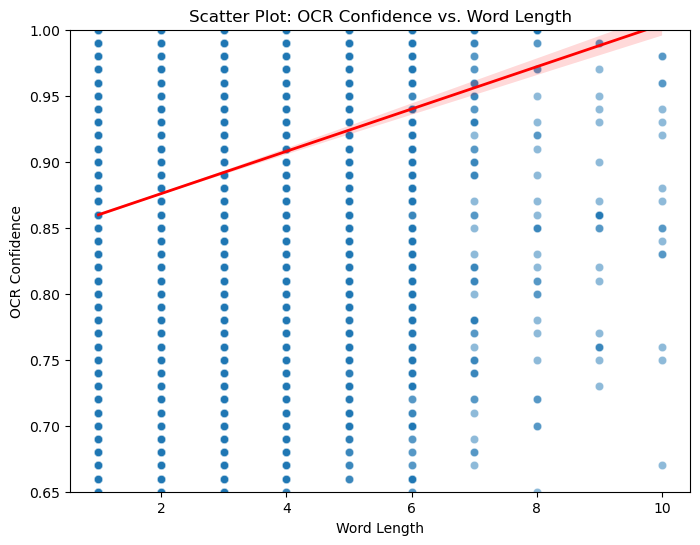

In [3]:
# plot 1: scatter plot of word length vs. OCR confidence
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_filtered["length"], y=df_filtered["confidence"], alpha=0.5)

# red regression line
sns.regplot(x=df_filtered["length"], y=df_filtered["confidence"], scatter=False, color="red", line_kws={"linewidth": 2})

# y-axis limit between 0.65 and 1 (because 0.65 minimum confidence set during data creation)
plt.ylim(0.65, 1)

plt.xlabel("Word Length")
plt.ylabel("OCR Confidence")
plt.title("Scatter Plot: OCR Confidence vs. Word Length")

plt.show()

In [4]:
# filter words with more than 15 characters
long_words = df[df["word_JAP"].str.len() > 15][["word_JAP", "word_US"]]

print(long_words)

                   word_JAP                                word_US
10461      アニメパキスベシャルブックレット             Anime Paki Special Booklet
12679    ドユアチヨコレトユラボレツョンツャツ  Douya Chocolate Yura Bore Tsyon Paste
28671      チャンビオンコミックスエクストラ                  Champion Comics Extra
29251     テセソビオソユミックスエクスドラン             Tesse Sobio Soy Mix Exdran
29844    シヨンバキスペシャルブツクレツトベヅ         Shionbaki Special Booklet Bezu
31037  レアニメションバキスペシャルブックレット       Reanimation Baki Special Booklet
34091      チャンビオンコミツクスエクストラ                  Champion Comics Extra
34206      チャンビオンコミツクスエクストラ                  Champion Comics Extra
34643     オリジナルチャンピオンマクワッペン             Original Champion McPappen


In [5]:
# jitter strength
jitter_strength = 0.1  # Adjust this value as needed

# create jittered columns
df_filtered["jittered_length"] = df_filtered["length"] + np.random.uniform(-jitter_strength, jitter_strength, len(df_filtered))
df_filtered["jittered_confidence"] = df_filtered["confidence"] + np.random.uniform(-jitter_strength, jitter_strength, len(df_filtered))


In [6]:
# KDE calculation using jittered values
xy = np.vstack([df_filtered['jittered_length'], df_filtered['jittered_confidence']])
kde = gaussian_kde(xy)  
density = kde(xy)  

# normalize density values
norm_density = (density - np.min(density)) / (np.max(density) - np.min(density))

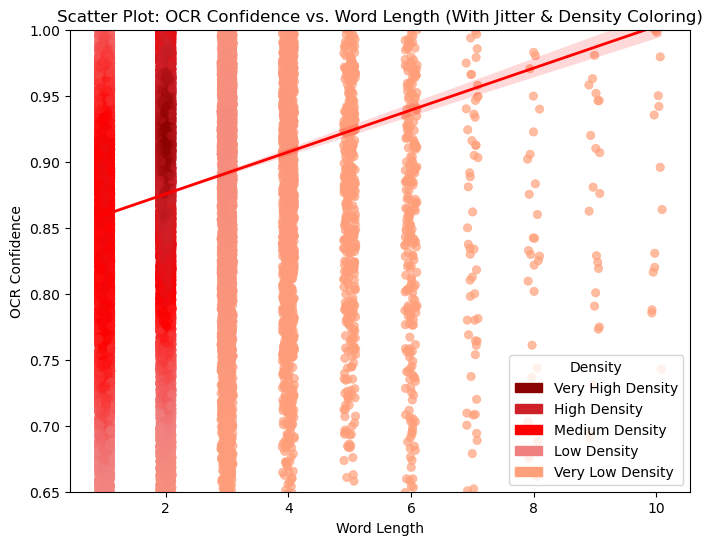

In [7]:
# custom red palette (light red to dark red)
custom_reds = LinearSegmentedColormap.from_list(
    "custom_reds", ["#ffa07a", "#f08080", "#ff0000", "#ce2029", "#8b0000"]
)

# plot 1: scatter plot with density-based coloring
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_filtered["jittered_length"], 
    y=df_filtered["jittered_confidence"], 
    alpha=0.7, 
    hue=norm_density,
    palette=custom_reds,  # Apply custom red gradient
    edgecolor=None
)

# Regression line
sns.regplot(x=df_filtered["jittered_length"], y=df_filtered["jittered_confidence"], scatter=False, color="red", line_kws={"linewidth": 2})

# Set y-axis limit between 0.65 and 1
plt.ylim(0.65, 1)

plt.xlabel("Word Length")
plt.ylabel("OCR Confidence")
plt.title("Scatter Plot: OCR Confidence vs. Word Length (With Jitter & Density Coloring)")

legend_labels = [
    mpatches.Patch(color="#8b0000", label="Very High Density"),
    mpatches.Patch(color="#ce2029", label="High Density"),
    mpatches.Patch(color="#ff0000", label="Medium Density"),
    mpatches.Patch(color="#f08080", label="Low Density"),
    mpatches.Patch(color="#ffa07a", label="Very Low Density"),
]

plt.legend(handles=legend_labels, title="Density", loc="lower right")

plt.show()

C:\Users\andne\AppData\Local\Temp\ipykernel_13780\1703224322.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


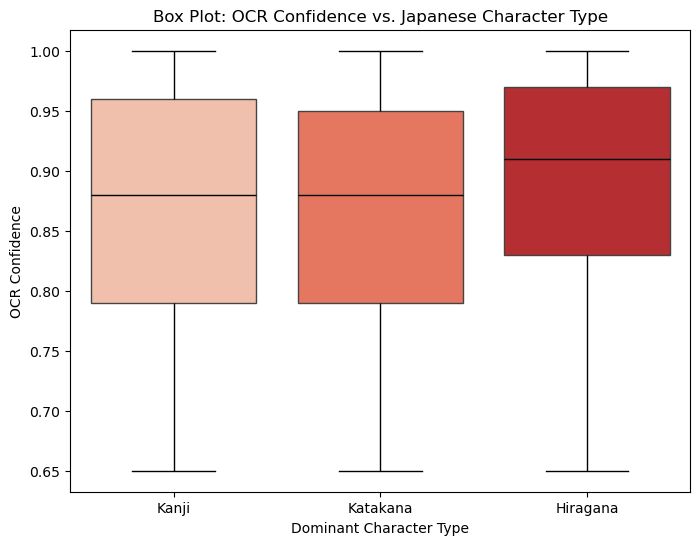

In [8]:
# function to find dominant character type
def classify_character_type(row):
    max_ratio = max(row["hiragana_ratio"], row["katakana_ratio"], row["kanji_ratio"])
    if max_ratio == row["kanji_ratio"]:
        return "Kanji"
    elif max_ratio == row["katakana_ratio"]:
        return "Katakana"
    else:
        return "Hiragana"

# apply classification
df_filtered["char_type"] = df_filtered.apply(classify_character_type, axis=1)

# plot 2: box plot
plt.figure(figsize=(8, 6))
sns.boxplot(
    x="char_type", 
    y="confidence", 
    data=df_filtered, 
    palette="Reds",
    whiskerprops=dict(color="black"),  # whiskers
    capprops=dict(color="black"),  # caps
    medianprops=dict(color="black")  # median line
)

plt.xlabel("Dominant Character Type")
plt.ylabel("OCR Confidence")
plt.title("Box Plot: OCR Confidence vs. Japanese Character Type")

plt.show()

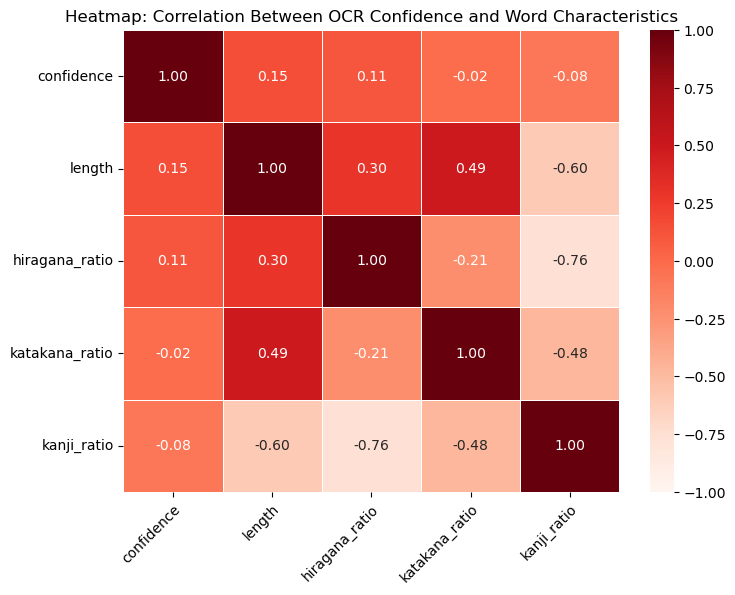

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# use only relevant numerical columns
correlation_data = df_filtered[["confidence", "length", "hiragana_ratio", "katakana_ratio", "kanji_ratio"]]

# correlation matrix
corr_matrix = correlation_data.corr()

# plot 3: heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix, 
    annot=True,  # show correlation values
    cmap="Reds", 
    fmt=".2f",  # format numbers to 2 decimal places
    linewidths=0.5,  # add lines between cells for clarity
    vmin=-1, vmax=1  # ensure consistent color scaling
)

# tilt x axis names
plt.xticks(rotation=45, ha="right", rotation_mode="anchor", x=0.1)

plt.title("Heatmap: Correlation Between OCR Confidence and Word Characteristics")
plt.show()


Inferences and Explanations of the Visualization for Q1:
1. OCR confidence increases with word length
- It is possible that shorter words suffer from lack of context or character misinterpretation. In addition, longer words usually do not include complex kanji symbols (most words can be written with few logographic kanji characters, but many alphabetic hiragana). OCR confidence performs, in general, better on words that are simpler to read (easy characters with few strokes), resulting in better confidence of their extraction.

2. OCR confidence better on hiragana dominant words
- As stated previously, since hiragana characters are simpler than kanji or katakana characters, OCR might have an easier time recognizing them, resulting in better accuracy. Its also important to take into consideration manga fonts, as these can significantly affect the looks of all characters on a page, further reducing accuracy for complex characters.

3. Heatmap shows slight positive correlation of confidence for the variables of word length and hiragana ratio, while having a slight negative correlation for the variables of katakana ratio and kanji ratio words. These results confirm the results of #1 and #2. Its also interesting to note that katakana ratio words (representing words of foreign origin) are not used often in natural text, and this reduced usage may limit OCR's ability to read katakana properly.

In [10]:
# list of useless words to filter out
stopwords = {
    "the", "a", "an", "and", "or", "but", "if", "so", "because",
    "in", "on", "at", "to", "from", "with", "by", "about", "of",
    "is", "are", "was", "were", "be", "being", "been", "am",
    "have", "has", "had", "do", "does", "did", "can", "could",
    "will", "would", "shall", "should", "must", "may", "might",
    "this", "that", "these", "those", "there", "here", "where",
    "when", "how", "say", "said", "tell", "told", "see", "saw",
    "look", "looked", "come", "go", "went", "take", "took",
    "make", "made", "get", "got", "know", "knew", "think",
    "thought", "want", "wanted", "like", "liked", "need",
    "needed", "use", "used", "find", "found", "give", "gave",
    "work", "works", "working", "try", "tried", "ask", "asked",
    "good", "bad", "better", "best", "worst", "big", "small",
    "little", "huge", "tiny", "old", "new", "young", "great",
    "nice", "mean", "strong", "weak", "happy", "sad",
    "I", "me", "my", "mine", "you", "your", "yours",
    "he", "him", "his", "she", "her", "hers", "it", "its",
    "we", "us", "our", "ours", "they", "them", "their", "theirs",
    "yes", "no", "maybe", "okay", "really", "very", "just", "even", "still", "yet",
    "oh", "uh", "um", "hmm", "ah", "haha", "lol", "hmm", "what"
}

C:\Users\andne\AppData\Local\Temp\ipykernel_13780\3306789585.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(
C:\Users\andne\AppData\Local\Temp\ipykernel_13780\3306789585.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(
C:\Users\andne\AppData\Local\Temp\ipykernel_13780\3306789585.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


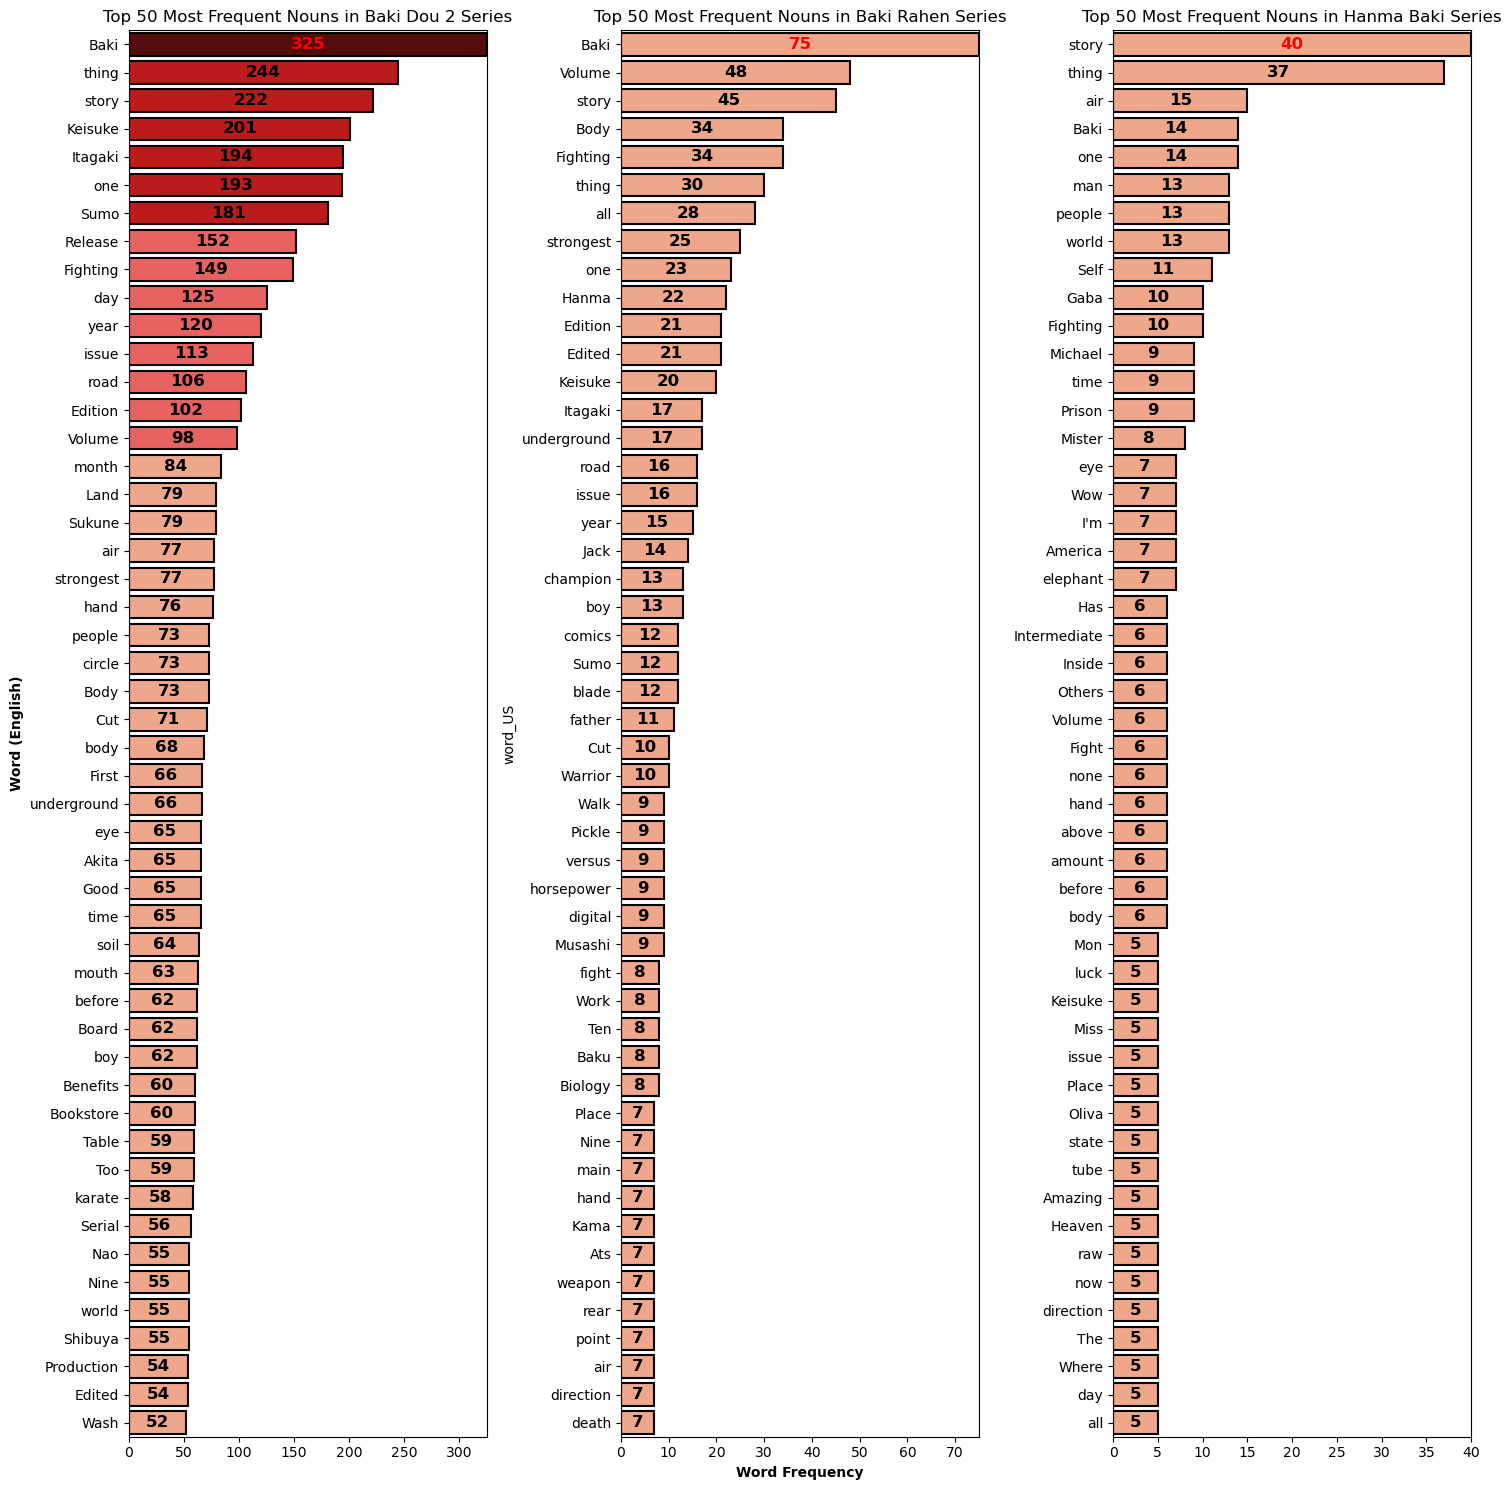

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Custom red color range (from lightest to darkest)
custom_reds = ["#ffa07a", "#ff4c4c", "#d60000", "#a00000", "#600000"]  # Reversed order

# Filter for nouns only
df_word_freq = df[df["word_POS"] == "noun"]

# Remove words which contain spaces or numbers
df_word_freq = df_word_freq[~df_word_freq["word_US"].str.contains(r"\s|\d", na=False, regex=True)]

# Filter out not significant words from dataframe
df_word_freq = df_word_freq[~df_word_freq["word_US"].isin(stopwords)]

# Total occurrences of words per series
word_counts = df_word_freq.groupby(["img_series", "word_US"])["word_US"].count().reset_index(name="word_count")

# Sort by frequency for each series
top_n = 50
word_counts_top = word_counts.sort_values(by="word_count", ascending=False).groupby("img_series").head(top_n)

# Get global min and max word frequency for consistent color mapping
global_min = word_counts_top["word_count"].min()
global_max = word_counts_top["word_count"].max()

# Function to map word count to the custom red color range
def map_to_custom_reds(value, vmin, vmax):
    norm_value = (value - vmin) / (vmax - vmin)  # Normalize to 0-1
    color_index = int(norm_value * (len(custom_reds) - 1))  # Scale to color list
    return custom_reds[color_index]

# Plot 1: Bar graphs
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

# Loop over each series and create individual bar plots
for idx, series in enumerate(word_counts_top['img_series'].unique()):
    ax = axes[idx]
    data = word_counts_top[word_counts_top["img_series"] == series]

    # Find the highest frequency value in this specific graph
    max_value = data["word_count"].max()

    # Map colors based on the full dataset range
    bar_colors = [map_to_custom_reds(value, global_min, global_max) for value in data["word_count"]]

    # Create bar plot with custom colors
    bars = sns.barplot(
        x="word_count", 
        y="word_US", 
        data=data, 
        ax=ax,
        palette=bar_colors
    )

    # Add black edge color to each bar
    for bar in bars.patches:
        bar.set_edgecolor("black")
        bar.set_linewidth(1.5)

    # Add word frequency inside each bar, highlight highest one in red ONLY for Baki Dou 2
    for i, value in enumerate(data["word_count"]):
        # Highlight the max value in Baki Dou 2 graph only
        text_color = "white" if series == "Baki Dou 2" and value == max_value else "black"
        ax.text(value / 2, i, str(value), ha='center', va='center', fontsize=12, color=text_color, fontweight="bold")

    # Custom title with bold series name
    adjusted_series = series.replace("Hanma_Baki", "Hanma Baki")
    title = f"Top {top_n} Most Frequent Nouns in {adjusted_series} Series"
    ax.set_title(title, fontweight='normal')

    # Set y-axis label for the left-most plot
    if idx == 0:
        ax.set_ylabel("Word (English)", fontweight='bold')

    # Set x-axis label for the middle plot
    if idx == 1:
        ax.set_xlabel("Word Frequency", fontweight='bold')

    # Remove x-axis label for the left-most and right-most plots
    if idx == 0:
        ax.set_xlabel('')
    if idx == 2:
        ax.set_xlabel('')

    # Remove y-axis label for the rightmost plot
    if idx == 2:
        ax.set_ylabel('')

    # Set x-axis limits based on each series' max frequency
    ax.set_xlim(0, data["word_count"].max())

# Adjust layout
plt.tight_layout()
plt.show()
